# Introduction and motivation

Collaborative investment platforms have seen massive growth during the past few years, with especially the pandemic accelerating growth of consumer investing. These platforms allow users to share analysis on companies, and provide their opinions on what people should or should not be investing in. The attraction of these platforms is for people to be able to beat the general market trends to rake in more profit. The margin by which you are beating the market is known as alpha. Enter SeekingAlpha. SeekingAlpha is a collaborative investment platform purely focused on users being able to provide stock tips and analysis on selected companies.

The platform enables users to compare companies within published articles on the site. This work attempts to see if these comparison networks have some sort of inherent structure within them. Initially this data was scraped during the autumn of 2020, for a bachelor's thesis project. The network itself formed by companies as nodes that are linked to each other if they appear in an article together. As the network's nodes are companies, it is easy to see how they could have several different attributes that can be found online. The attributes chosen for this work ended up being the sector, EBITDA (earning before interest, taxes, deprecation, and amortization), and the market cap of the company. These reflect the area of expertise, profitability, and scale of the companies, which seem like apt ways to compare them against each other.

The subset of data chosen for this network ended up being the set of 'Short ideas' articles from SeekingAlpha. This was due to the moderate size of the network. Initially the network consisted of 2764 nodes, however, after scraping data using the tickers of the companies, only 1879 connected companies remained in the network due to missing data for several companies. The data for nodes were found using yfinance Python API and the preprocessing of the network was done within the Python script found within preprocess_network.py file. Some functions found within the script will not be relevant for this repo, due to inability to upload the scraped json files to Github, as there is a size limit for files to be uploaded to Github. The network data before any preprocessing can be found within the SA_adj_list.txt file.

After the construction of the network a visualization for the network was produced. The following visualization was produced using Gephi, with sectors as the node colors, and size of nodes scaled using the market cap of company. The visualization clearly shows some structure within the sectors of companies, alongside a focus on a few different sectors within the network. Some larger nodes (high market cap) also seem like relatively central nodes within their communities.

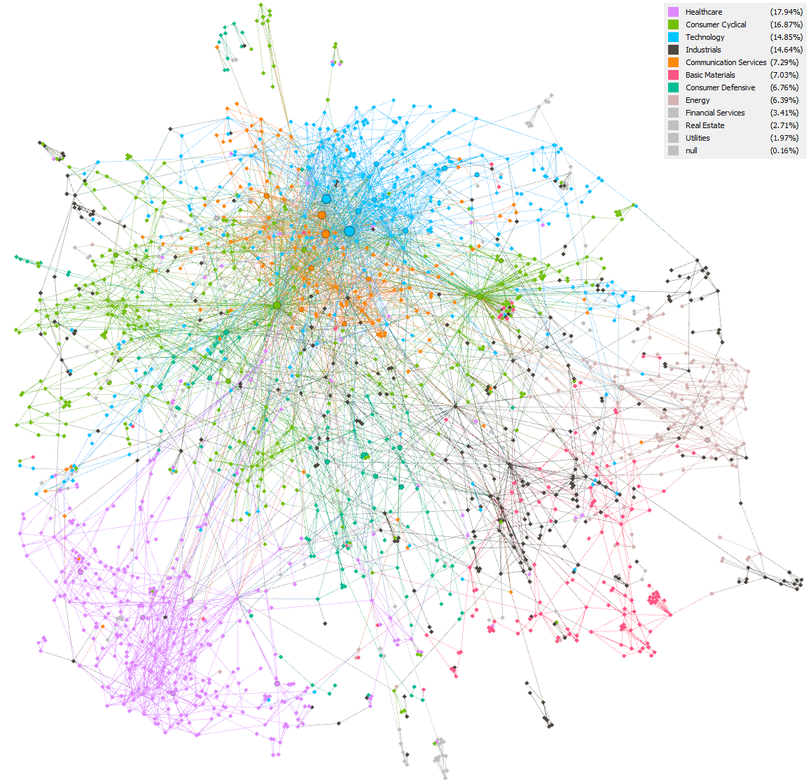

# Analysis of SA network alongside comparisons to ER/BA random networks

In this section we will initially look at general metrics of the SeekingAlpha network, after which we will proceed to comparing the network with some random networks. This will be done to see what kind of attributes the network has, which can be used for e.g., seeing what kind of real-life networks are similar to that of the SA network.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

Reading network data and displaying certain features of the SA network:

In [2]:
G = nx.read_gexf('SA.gexf')
nodes = G.nodes()
edges = G.edges()
N = len(nodes)
L = len(edges)
print(f'Number of nodes in SA network: {N}')
print(f'Number of links in SA network: {L}')
print(f'Average degree of SA network: {2*L/N:.2f}')
print(f'Density of SA network: {2*L/(N*(N-1)):.5f}')

Number of nodes in SA network: 1879
Number of links in SA network: 4291
Average degree of SA network: 4.57
Density of SA network: 0.00243


It does seem like the SA network is quite sparse, with only average degree of under five. The network also consists of only a single component, due to some pruning operations done in the preprocessing of the network.

Now we can also define random networks with same amount of nodes and same or similar amount of links

In [3]:
G_er = nx.erdos_renyi_graph(N, 2*L/(N*(N-1)))
G_ba = nx.barabasi_albert_graph(N, round(L/N))

Checking initially simply the maximum degrees of all networks.

In [4]:
print(f'SA network maximum degree: {max(dict(G.degree()).values())}')
print(f'ER network maximum degree: {max(dict(G_er.degree()).values())}')
print(f'BA network maximum degree: {max(dict(G_ba.degree()).values())}')

SA network maximum degree: 145
ER network maximum degree: 13
BA network maximum degree: 99


Now initially seems clear that SA network is more similar to BA network. Now defining function for plotting data, so this can be verified further

In [5]:
def plot_degree_distribution(G, title=None, log_scale=False):
    k = [degree for _, degree in G.degree()]
    unique_degs = len(np.unique(k))
    n_bins = 30 if unique_degs >= 30 else unique_degs
    if log_scale:
        bins = np.logspace(np.log10(np.min(k)), 
                           np.log10(np.max(k)), 
                           num=n_bins)
        plt.hist(k, density=True, bins=bins)
        plt.xscale('log')
        plt.yscale('log',nonpositive='clip')
    else:
        plt.hist(k, n_bins, density=True)
    plt.title(title)
    plt.xlabel('degree')
    plt.ylabel('%')
    plt.xlim(min(k), max(k))
    plt.show()

Plotting the degree distributions for all the networks

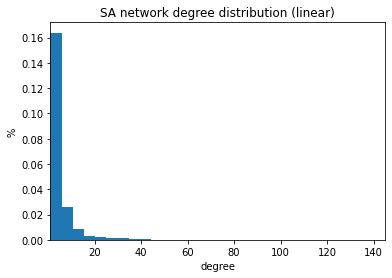

In [6]:
plot_degree_distribution(G, 'SA network degree distribution (linear)', False)

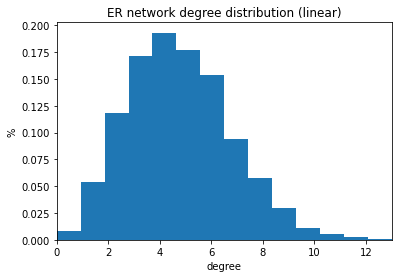

In [7]:
plot_degree_distribution(G_er, 'ER network degree distribution (linear)', False)

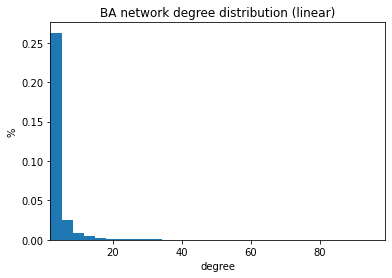

In [8]:
plot_degree_distribution(G_ba, 'BA network degree distribution (linear)', False)

Clearly it seems like the SA network is much more comparable to the scale-free BA network. To confirm this finally we can plot the two networks in log-scale also using log-scale binning.

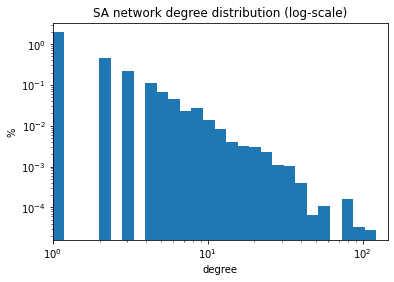

In [9]:
plot_degree_distribution(G, "SA network degree distribution (log-scale)", True)

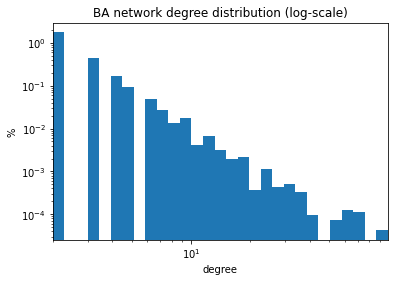

In [10]:
plot_degree_distribution(G_ba, "BA network degree distribution (log-scale)", True)

Now it is clear that they exhibit exhibit extremely similar qualities, so the SeekingAlpha network can be thought of as having scale-free properties. Now for more statistics of the network we can calculate and contrast the first, second, and third moments of the networks. The first moment should be similar with all networks, as it was used to define the two random networks. However, BA network's first moment is rounded down, which will slightly affect the results.

In [11]:
 def nth_moment(G, n):
    degrees = np.array(list(dict(G.degree).values()))
    return np.sum(degrees**n)/len(degrees)

In [12]:
moments = ['First', 'Second', 'Third']
for i, nth in enumerate(moments):
    print(f'{nth} moment of SA network: {nth_moment(G, i+1)}')
    print(f'{nth} moment of ER network: {nth_moment(G_er, i+1)}')
    print(f'{nth} moment of BA network: {nth_moment(G_ba, i+1)}\n')

First moment of SA network: 4.567323044172432
First moment of ER network: 4.624800425758382
First moment of BA network: 3.9957424161788184

Second moment of SA network: 85.48696114954762
Second moment of ER network: 26.06492815327302
Second moment of BA network: 44.29377328366152

Third moment of SA network: 5033.624268227781
Third moment of ER network: 168.1160191591272
Third moment of BA network: 1686.3235763704097



Clearly it seems like the BA and SA network are most similar, however, the second and third moments are still clearly larger in SA network compared to the BA network. This could be due to the difference in the average degree of the networks, but as the difference is so large it is unlikely to be fully explained by that.

Now we can explore possible shortest path distributions between the networks. First we can calculate all possible shortest path lengths in the network. The following function calculates all possible shortest distances between nodes of the network and removes all distances from node to itself.

In [13]:
def get_shortest_path_vector(G):
    path_lengths_mat = np.zeros((len(G.nodes), len(G.nodes)))
    path_lengths = dict(nx.all_pairs_shortest_path_length(G))
    for i, (source, targets) in enumerate(path_lengths.items()):
        for j, (target, distance) in enumerate(targets.items()):
            path_lengths_mat[i,j] = distance
    path_lengths_mat = path_lengths_mat.reshape(-1).astype(int)
    return path_lengths_mat[path_lengths_mat > 0]

Then using the constructed function to calculate the shortest path lengths for all three graphs:

In [14]:
lengths_G = get_shortest_path_vector(G)
lengths_G_er = get_shortest_path_vector(G_er)
lengths_G_ba = get_shortest_path_vector(G_ba)

After which we can visualize the shortest path length distributions for all the graphs to further investigate the differences between them. Y-axis labels/scale is removed, as it is not necessarily relevant here. The general shape of the distribution is the important part here.

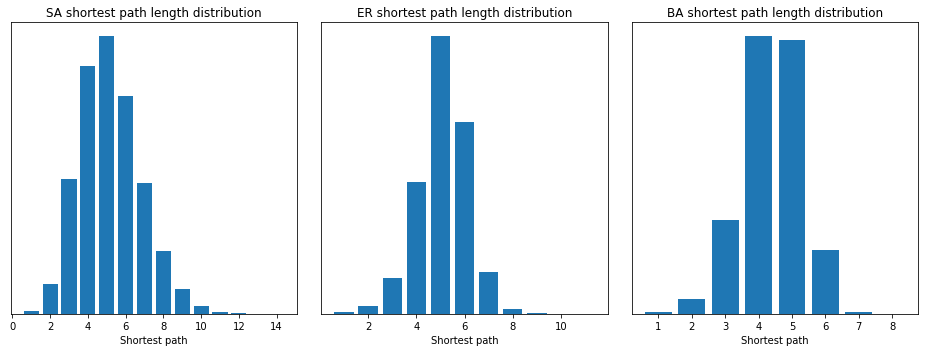

In [15]:
lengths_title = [
    (lengths_G, 'SA'),
    (lengths_G_er, 'ER'),
    (lengths_G_ba, 'BA')
]
fig, axs = plt.subplots(1, 3, figsize=(13,5), tight_layout=True)
axs[2]
for i, (lengths, title) in enumerate(lengths_title):
    bins, counts = np.unique(lengths, return_counts=True)
    axs[i].bar(bins, counts)
    axs[i].set_yticks([])
    axs[i].set_title(f'{title} shortest path length distribution')
    axs[i].set_xlabel('Shortest path')
plt.show()

Now the BA random network does show the shortest path lengths out of all the networks, while the SA network actually seems to be more in line with the ER network. This shows some differences between the SA network and a random scale-free network, which is contrary to all previous findings of the networks and shows that theoretical random models always end up having differences to real-life networks.